<a href="https://colab.research.google.com/github/ravi4biz/COVID-19/blob/master/Covid_By_The_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs
!pip install pycountry_convert 
!pip install folium
!pip install calmap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap
import seaborn as sns

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Cases and Death counts include confirmed and probable (where reported).
Recovered cases are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number. US state-level recovered cases are from COVID Tracking Project.

Active cases = total cases - total recovered - total deaths.

Incidence Rate = cases per 100,000 persons.

Case-Fatality Ratio (%) = Number recorded deaths / Number cases.



In [ ]:
# Retriving Dataset 
# The data id from "COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University" the url: https://github.com/CSSEGISandData/COVID-19.  
# Dashboard https://systems.jhu.edu/research/public-health/ncov/     
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

#**** Removed this comment
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [ ]:
df.tail(20)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
171,Thailand,2021-01-18 16:21:53,15.870032,100.992541,12423.0,70.0,9206.0,3147.0,17.798000,NaN,NaN,0.563471,764,THA
172,Timor-Leste,2021-01-18 16:21:53,-8.874217,125.727539,52.0,0.0,49.0,3.0,3.944049,NaN,NaN,0.000000,626,TLS
173,Togo,2021-01-18 16:21:53,8.619500,0.824800,4302.0,73.0,3775.0,454.0,51.964448,NaN,NaN,1.696885,768,TGO
174,Trinidad and Tobago,2021-01-18 16:21:53,10.691800,-61.222500,7393.0,132.0,6930.0,331.0,528.263490,NaN,NaN,1.785473,780,TTO
175,Tunisia,2021-01-18 16:21:53,33.886917,9.537499,180090.0,5692.0,128992.0,45406.0,1523.782222,NaN,NaN,3.160642,788,TUN
176,Turkey,2021-01-18 16:21:53,38.963700,35.243300,2387101.0,23997.0,2262864.0,100240.0,2830.362114,NaN,NaN,1.005278,792,TUR
177,US,2021-01-18 16:21:53,40.000000,-100.000000,23952960.0,397672.0,NaN,23555288.0,7270.231048,NaN,NaN,1.660221,840,USA
178,Uganda,2021-01-18 16:21:53,1.373333,32.290275,38085.0,304.0,13083.0,24698.0,83.262281,NaN,NaN,0.798215,800,UGA
179,Ukraine,2021-01-18 16:21:53,48.379400,31.165600,1201894.0,21847.0,902481.0,277566.0,2748.206483,NaN,NaN,1.817714,804,UKR
180,United Arab Emirates,2021-01-18 16:21:53,23.424076,53.847818,256732.0,751.0,228364.0,27617.0,2595.769635,NaN,NaN,0.292523,784,ARE


In [ ]:
df_deaths.tail(20)

In [ ]:
##Renaming columns from the original data set to understandable and easy to use names
df.columns=['Country',
                         'LastUpdate',
                         'Lat',
                         'Long',
                         'Confirmed',
                         'Deaths',
                         'Recovered',
                         'Active',
                         'IncidentRate',
                         'PeopleTested',
                         'PeopleHospit',
                         'MortalityRate',
                         'UID',
                         'abr']

In [ ]:
df.columns

Index(['Country', 'LastUpdate', 'Lat', 'Long', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'IncidentRate', 'PeopleTested', 'PeopleHospit',
       'MortalityRate', 'UID', 'abr'],
      dtype='object')

Basic Stats

In [ ]:
##Visualize the main statistical features in the data set, for example mean, median, mode, and quartile breakdown of all of the features
##in the data set
df.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active,IncidentRate,PeopleTested,PeopleHospit,MortalityRate,UID
count,189.000000,189.000000,1.910000e+02,191.000000,1.870000e+02,1.910000e+02,189.000000,0.0,0.0,191.000000,191.000000
mean,19.579819,19.078569,4.983203e+05,10647.335079,2.805167e+05,2.130310e+05,1839.536291,NaN,NaN,2.091752,517.806283
std,23.961880,61.452720,2.040108e+06,37671.193878,9.949477e+05,1.735080e+06,2248.259419,NaN,NaN,2.791831,956.167976
min,-40.900600,-172.104600,1.000000e+00,0.000000,1.000000e+00,0.000000e+00,0.341670,NaN,NaN,0.000000,4.000000
25%,4.570900,-7.092600,5.635000e+03,79.000000,3.733500e+03,5.145000e+02,107.859776,NaN,NaN,0.930604,206.000000
50%,17.607789,20.168300,5.143700e+04,612.000000,2.666900e+04,5.360000e+03,793.021986,NaN,NaN,1.660221,422.000000
75%,40.463667,46.199616,2.262005e+05,4259.500000,1.522670e+05,2.903000e+04,3085.066777,NaN,NaN,2.512217,652.500000
max,64.963100,178.065000,2.395296e+07,397672.000000,1.021134e+07,2.355529e+07,11755.646153,NaN,NaN,28.977273,9999.000000


In [ ]:
##Number of deaths by quartile (25%,50%, and 75%)
df.Deaths.quantile([.25,.5,.75])

0.25      79.0
0.50     612.0
0.75    4259.5
Name: Deaths, dtype: float64

In [ ]:
##Finding the minimum, maximum, and mean value of deaths across the data set
df.Deaths.agg(['min','max','mean'])

min          0.000000
max     397672.000000
mean     10647.335079
Name: Deaths, dtype: float64

In [ ]:
##Identifying the correlation number between deaths and patients who recovered
df.Deaths.corr(df.Recovered)

0.8206931273525464

Plotting

In [ ]:
##Creating a new dataframe without longitude, latitude, and last update data
##Setting the index of the new datafram to the country name
##Dropping the feature of Country name from the column header
df_country_cases = df.copy().drop(['Lat','Long','LastUpdate'],axis=1)
df_country_cases.index = df_country_cases["Country"]
df_country_cases = df_country_cases.drop(['Country'],axis=1)

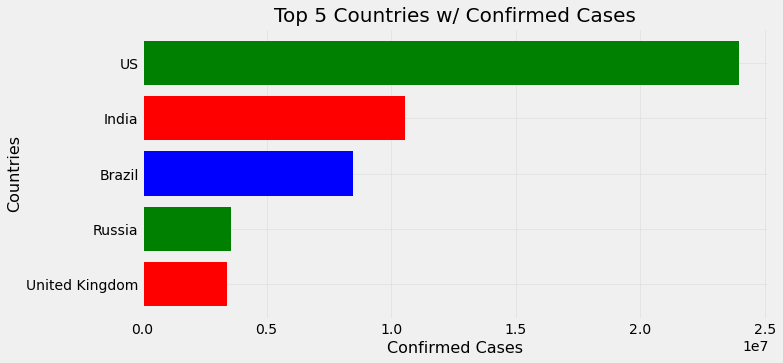

In [ ]:
##Creating a bar chart of the top 5 countries based on confirmed cases
##Setting the title of the table along with x and y axis labels to clearly show the given data
f = plt.figure(figsize=(10,5))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(df_country_cases.sort_values('Confirmed')["Confirmed"]
         .index[-5:],df_country_cases.sort_values('Confirmed')["Confirmed"]
         .values[-5:],color='RGB')
plt.xlabel("Confirmed Cases",fontsize=16)
plt.ylabel("Countries",fontsize=16)
plt.title("Top 5 Countries w/ Confirmed Cases",fontsize=20)
plt.grid(alpha=0.3)

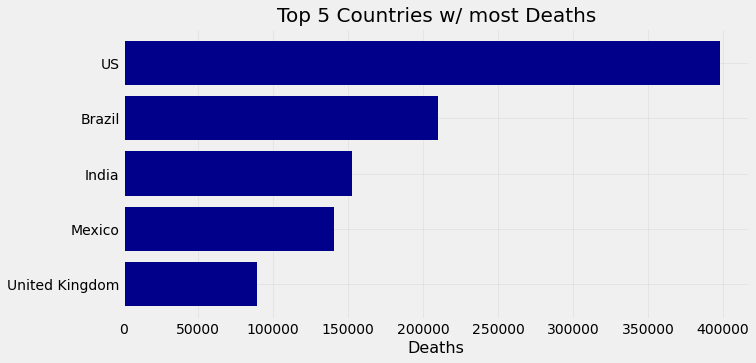

In [ ]:
##Creating a bar chart of the top 5 countries with the most deaths
d = plt.figure(figsize=(10,5))
d.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(df_country_cases.sort_values('Deaths')["Deaths"]
         .index[-5:],df_country_cases.sort_values('Deaths')["Deaths"]
         .values[-5:],color='darkblue')
plt.xlabel("Deaths",fontsize=16)
plt.title("Top 5 Countries w/ most Deaths",fontsize=20)
plt.grid(alpha=0.3)

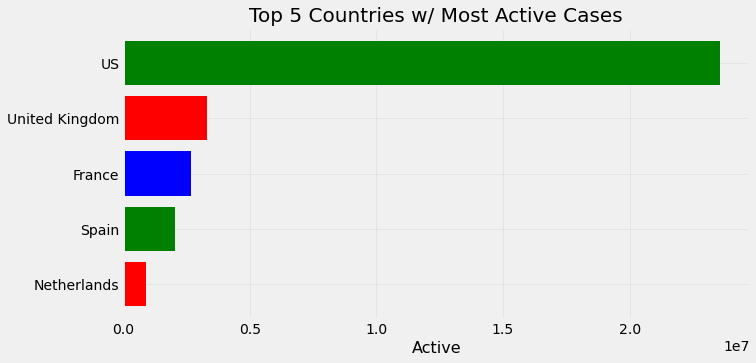

In [ ]:
##Creating a bar chart of the top 5 countries with the most number of active cases
a = plt.figure(figsize=(10,5))
a.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(df_country_cases.sort_values('Active')["Active"]
         .index[-5:],df_country_cases.sort_values('Active')["Active"]
         .values[-5:],color='RGB')
plt.xlabel("Active",fontsize=16)
plt.title("Top 5 Countries w/ Most Active Cases",fontsize=20)
plt.grid(alpha=0.3)

In [ ]:
##Creating a visual representation by country of all features in the original data set(excluding lat, long, and last update)
##Highlighted values are the largest for each feature
df_country_cases["Mortality Rate (per 100)"] = np.round(100*df_country_cases["Deaths"]/df_country_cases["Confirmed"],2)
df_country_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Purples',subset=["Confirmed"])\
                        .background_gradient(cmap='Greens',subset=["Deaths"])\
                        .background_gradient(cmap='Reds',subset=["Recovered"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,IncidentRate,PeopleTested,PeopleHospit,MortalityRate,UID,abr,Mortality Rate (per 100)
Country,,,,,,,,,,,
US,23952960.000000,397672.000000,nan,23555288.000000,7270.231048,nan,nan,1.660221,840,USA,1.660000
India,10571773.000000,152419.000000,10211342.000000,208012.000000,766.068073,nan,nan,1.441754,356,IND,1.440000
Brazil,8488099.000000,209847.000000,7522851.000000,755401.000000,3993.283120,nan,nan,2.472250,76,BRA,2.470000
Russia,3552888.000000,65059.000000,2947479.000000,540350.000000,2434.577823,nan,nan,1.831158,643,RUS,1.830000
United Kingdom,3405782.000000,89431.000000,8193.000000,3308158.000000,5016.913354,nan,nan,2.625858,826,GBR,2.630000
France,2969091.000000,70422.000000,215272.000000,2683397.000000,4548.691972,nan,nan,2.371837,250,FRA,2.370000
Italy,2390101.000000,82554.000000,1760489.000000,547058.000000,3953.074326,nan,nan,3.453996,380,ITA,3.450000
Turkey,2387101.000000,23997.000000,2262864.000000,100240.000000,2830.362114,nan,nan,1.005278,792,TUR,1.010000
Spain,2252164.000000,53314.000000,150376.000000,2048474.000000,4816.970277,nan,nan,2.367234,724,ESP,2.370000


In [ ]:
df_country_cases.iloc[:,:-1].corr(method='kendall').style.background_gradient(cmap='coolwarm')

,Confirmed,Deaths,Recovered,Active,IncidentRate,PeopleTested,PeopleHospit,MortalityRate,UID
Confirmed,1.000000,0.843522,0.916854,0.766596,0.488349,nan,nan,0.188274,-0.018683
Deaths,0.843522,1.000000,0.790979,0.745324,0.428782,nan,nan,0.344694,-0.025565
Recovered,0.916854,0.790979,1.000000,0.680844,0.450059,nan,nan,0.178369,-0.054913
Active,0.766596,0.745324,0.680844,1.000000,0.447035,nan,nan,0.208925,-0.005626
IncidentRate,0.488349,0.428782,0.450059,0.447035,1.000000,nan,nan,0.049314,-0.041653
PeopleTested,nan,nan,nan,nan,nan,nan,nan,nan,nan
PeopleHospit,nan,nan,nan,nan,nan,nan,nan,nan,nan
MortalityRate,0.188274,0.344694,0.178369,0.208925,0.049314,nan,nan,1.000000,-0.008498
UID,-0.018683,-0.025565,-0.054913,-0.005626,-0.041653,nan,nan,-0.008498,1.000000


In [ ]:
##Replacing Nan values in the location feature with null values
df_confirmed= df_confirmed.replace(np.nan,'',regex= True)
df_deaths= df_deaths.replace(np.nan,'',regex=True)

In [ ]:
##Creating a world map view where users are able to hover over locations and retrieve Covid-19 data based on region
##Some regions are not applicable *working on this*
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='# ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map


Filtering

In [ ]:
##Filtering the data by number of deaths greater than a certain value
df[df.Deaths >= 20000]

In [ ]:
##Filtering the data by the number of confimed cases greater than a certain value
df[df.Confirmed >=5000000 ]

In [ ]:
##Combining filters to create a conditional statement satisfying both commands
df[(df.Deaths >= 20000) & (df.Confirmed >=5000000)]

Grouping using Groupby


In [ ]:
df_covid19 =df
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [ ]:
df.columns

Index(['Country', 'LastUpdate', 'Lat', 'Long', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'IncidentRate', 'PeopleTested', 'PeopleHospit',
       'MortalityRate', 'UID', 'abr'],
      dtype='object')

In [ ]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [ ]:
df_continents_cases = df_covid19.copy().drop(['Lat','Long','country','LastUpdate'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

In [ ]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,IncidentRate,PeopleTested,PeopleHospit,MortalityRate,UID,Mortality Rate (per 100)
continent,,,,,,,,,,
Africa,2983144.000000,71382.000000,2431184.000000,480578.000000,16805.248759,0.000000,0.000000,108.005273,24764,2.390000
Asia,21075798.000000,342165.000000,19576149.000000,1157484.000000,63833.366089,0.000000,0.000000,89.023802,18454,1.620000
Australia,31636.000000,945.000000,28734.000000,1957.000000,183.253305,0.000000,0.000000,9.224025,3534,2.990000
Europe,25592350.000000,581005.000000,12238107.000000,11301869.000000,178008.478225,0.000000,0.000000,82.470634,18538,2.270000
North America,24959448.000000,535774.000000,2449555.000000,534124.000000,30850.949559,0.000000,0.000000,46.196163,8292,2.150000
Others,329618.000000,5754.000000,287539.000000,36325.000000,9384.716089,0.000000,0.000000,29.855385,20611,1.750000
South America,13715889.000000,372351.000000,12331993.000000,1011545.000000,24683.334133,0.000000,0.000000,34.554191,4708,2.710000
